<a href="https://colab.research.google.com/github/i-ganza007/AgriChatBot-Summative/blob/main/Trial_Baseline_Min.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import re
import unicodedata
from collections import Counter

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score

import tensorflow as tf
from transformers import T5Tokenizer, TFAutoModelForSeq2SeqLM, create_optimizer


In [ ]:
from transformers import T5Tokenizer, TFAutoModelForSeq2SeqLM
from huggingface_hub import snapshot_download

MODEL_NAME = "t5-small"

try:
    tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME, trust_remote_code=False)
    model = TFAutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME, trust_remote_code=False)
except Exception as e:
    print(f"⚠️ Normal loading failed due to: {e}\nDownloading local snapshot instead...")
    local_dir = snapshot_download(repo_id=MODEL_NAME)
    tokenizer = T5Tokenizer.from_pretrained(local_dir)
    model = TFAutoModelForSeq2SeqLM.from_pretrained(local_dir)

print("\n✅ Model and tokenizer loaded successfully!")

text = "translate English to French: The farmer grows rice."
inputs = tokenizer(text, return_tensors="tf")
outputs = model.generate(**inputs)
print("\nResult:", tokenizer.decode(outputs[0], skip_special_tokens=True))


All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.



✅ Model and tokenizer loaded successfully!

Result: L'agriculteur cultive du riz.


In [ ]:
import transformers
print(f"Transformers version: {transformers.__version__}")

# Fix for Transformers v4.45+ chat template bug
if hasattr(transformers, '__version__'):
    major, minor = map(int, transformers.__version__.split('.')[:2])
    if major >= 4 and minor >= 45:
        print("⚠ Detected Transformers v4.45+, applying chat template workaround...")
        import transformers.utils.hub as hub_utils
        original_list_repo_templates = hub_utils.list_repo_templates

        def patched_list_repo_templates(*args, **kwargs):
            try:
                return original_list_repo_templates(*args, **kwargs)
            except Exception:
                return []

        hub_utils.list_repo_templates = patched_list_repo_templates
        print("✓ Workaround applied!")

from transformers import T5Tokenizer, TFAutoModelForSeq2SeqLM, create_optimizer

try:
    from rouge_score import rouge_scorer
    ROUGE_AVAILABLE = True
except ImportError:
    ROUGE_AVAILABLE = False

Transformers version: 4.44.2


In [ ]:
import pandas as pd
df = pd.read_parquet("hf://datasets/KisanVaani/agriculture-qa-english-only/data/train-00000-of-00001.parquet")
df = df[['question', 'answers']].drop_duplicates().dropna()
print(f"Dataset shape: {df.shape}")

Dataset shape: (2331, 2)


In [ ]:
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [ ]:
def clean_text(text):
    """Clean and normalize text"""
    if not isinstance(text, str):
        return ""

    text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

print("Cleaning text...")
df['question_cleaned'] = df['question'].apply(clean_text)
df['answers_cleaned'] = df['answers'].apply(clean_text)

df = df[(df['question_cleaned'].str.len() > 0) & (df['answers_cleaned'].str.len() > 0)]
print(f"Dataset shape after cleaning: {df.shape}")

Cleaning text...
Dataset shape after cleaning: (2302, 4)


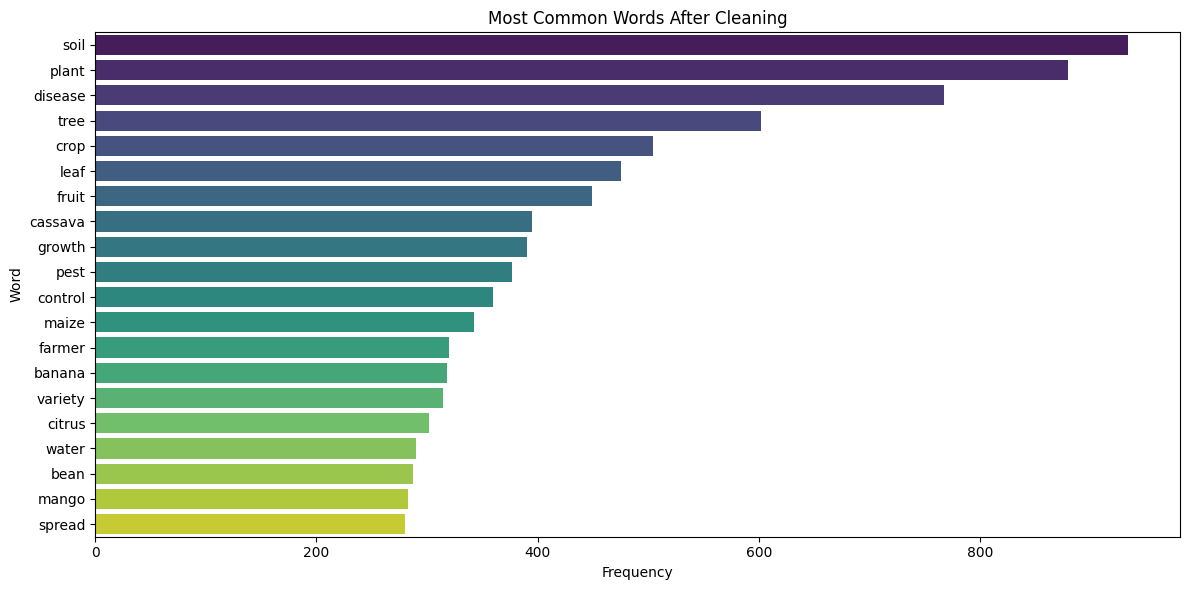

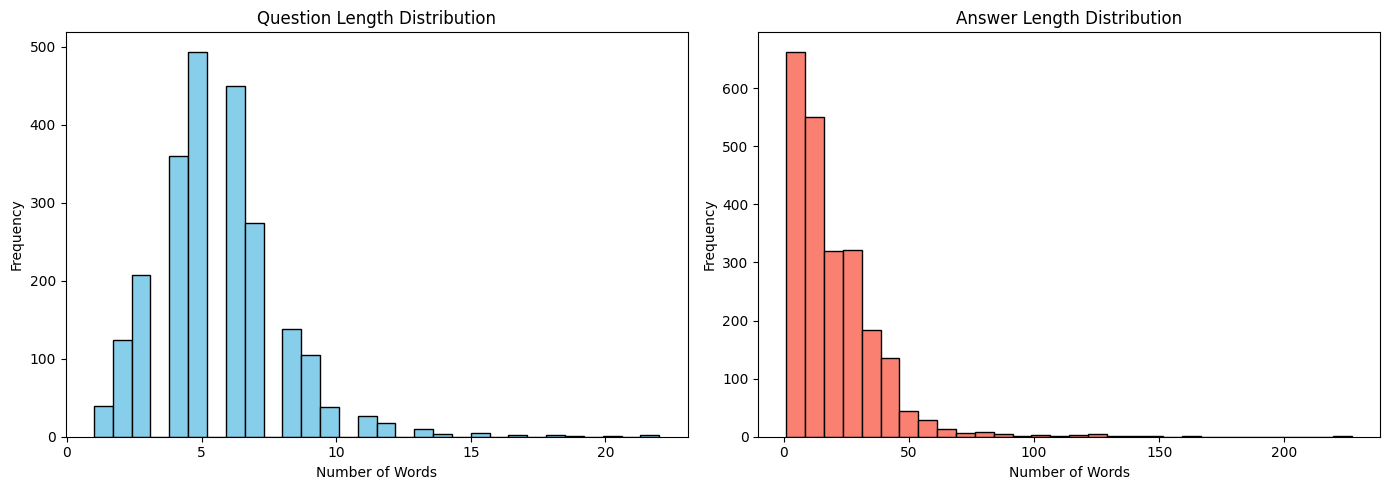

Avg question length: 5.56 words
Avg answer length: 19.76 words


In [ ]:
all_words = ' '.join(df['question_cleaned'].tolist() + df['answers_cleaned'].tolist()).split()
common_words = Counter(all_words).most_common(20)
df_common_words = pd.DataFrame(common_words, columns=['word', 'count'])

plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='word', data=df_common_words, palette='viridis')
plt.title('Most Common Words After Cleaning')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.tight_layout()
plt.show()

df['question_length'] = df['question_cleaned'].str.split().str.len()
df['answer_length'] = df['answers_cleaned'].str.split().str.len()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(df['question_length'], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Question Length Distribution')
axes[0].set_xlabel('Number of Words')
axes[0].set_ylabel('Frequency')

axes[1].hist(df['answer_length'], bins=30, color='salmon', edgecolor='black')
axes[1].set_title('Answer Length Distribution')
axes[1].set_xlabel('Number of Words')
axes[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

print(f"Avg question length: {df['question_length'].mean():.2f} words")
print(f"Avg answer length: {df['answer_length'].mean():.2f} words")

In [ ]:
from transformers import T5Tokenizer, TFAutoModelForSeq2SeqLM
from huggingface_hub import snapshot_download
import tensorflow as tf
MODEL_NAME = "t5-small"
MAX_INPUT_LENGTH = 64
MAX_TARGET_LENGTH = 128
BATCH_SIZE = 8
EPOCHS = 3
LEARNING_RATE = 5e-5
VALIDATION_SPLIT = 0.1

print("GPUs available:", len(tf.config.list_physical_devices('GPU')))

try:
    tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME, trust_remote_code=False)
    model = TFAutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME, trust_remote_code=False)
except Exception as e:
    print(f"⚠️ Normal loading failed due to: {e}\nDownloading local snapshot instead...")
    local_dir = snapshot_download(repo_id=MODEL_NAME)
    tokenizer = T5Tokenizer.from_pretrained(local_dir)
    model = TFAutoModelForSeq2SeqLM.from_pretrained(local_dir)

print("\n✅ Model and tokenizer loaded successfully!")

questions = ["question: " + q for q in df['question_cleaned'].tolist()]
answers = df['answers_cleaned'].tolist()

GPUs available: 0


All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.



✅ Model and tokenizer loaded successfully!


In [ ]:
original_questions = ["question: " + q for q in df['question'].tolist()]
original_answers = df['answers'].tolist()

print(f"Sample question (original): {df['question'].iloc[0][:100]}...")
print(f"Sample answer (original): {df['answers'].iloc[0][:100]}...")

question_tokens = tokenizer(
    original_questions,
    padding='max_length',
    truncation=True,
    max_length=MAX_INPUT_LENGTH,
    return_tensors="tf"
)

answer_tokens = tokenizer(
    original_answers,
    padding='max_length',
    truncation=True,
    max_length=MAX_TARGET_LENGTH,
    return_tensors="tf"
)

labels = tf.where(
    answer_tokens['input_ids'] == tokenizer.pad_token_id,
    -100,
    answer_tokens['input_ids']
)

indices = np.arange(len(original_questions))
train_idx, val_idx = train_test_split(indices, test_size=VALIDATION_SPLIT, random_state=42)

train_input_ids = tf.gather(question_tokens['input_ids'], train_idx)
train_attention_mask = tf.gather(question_tokens['attention_mask'], train_idx)
train_labels = tf.gather(labels, train_idx)

val_input_ids = tf.gather(question_tokens['input_ids'], val_idx)
val_attention_mask = tf.gather(question_tokens['attention_mask'], val_idx)
val_labels = tf.gather(labels, val_idx)

print(f"Training samples: {len(train_idx)}")
print(f"Validation samples: {len(val_idx)}")

Sample question (original): why is crop rotation important in farming?...
Sample answer (original): This helps to prevent soil erosion and depletion, and can also help to control pests and diseases...
Training samples: 2071
Validation samples: 231


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': train_input_ids,
        'attention_mask': train_attention_mask,
        'labels': train_labels
    },
    train_labels
)).shuffle(1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Building validation dataset...")
val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': val_input_ids,
        'attention_mask': val_attention_mask,
        'labels': val_labels
    },
    val_labels
)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"✓ Datasets created!")
print(f"  Training batches: {len(train_dataset)}")
print(f"  Validation batches: {len(val_dataset)}")

# Test that datasets are working
for batch in train_dataset.take(1):
    inputs, targets = batch
    print(f"  ✓ Batch shape check passed")
    print(f"    - Input IDs: {inputs['input_ids'].shape}")
    print(f"    - Attention Mask: {inputs['attention_mask'].shape}")
    print(f"    - Labels: {inputs['labels'].shape}")
    break

Building validation dataset...
✓ Datasets created!
  Training batches: 259
  Validation batches: 29
  ✓ Batch shape check passed
    - Input IDs: (8, 64)
    - Attention Mask: (8, 64)
    - Labels: (8, 128)


In [ ]:
import tf_keras

def masked_sparse_categorical_accuracy(y_true, y_pred):
    """Calculate accuracy ignoring padding tokens (-100)"""
    y_pred_ids = tf.argmax(y_pred, axis=-1, output_type=tf.int32)

    mask = tf.not_equal(y_true, -100)

    matches = tf.equal(y_true, tf.cast(y_pred_ids, y_true.dtype))
    matches = tf.logical_and(matches, mask)

    accuracy = tf.reduce_sum(tf.cast(matches, tf.float32)) / tf.reduce_sum(tf.cast(mask, tf.float32))
    return accuracy

optimizer = tf_keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(
    optimizer=optimizer,
    metrics=[masked_sparse_categorical_accuracy]
)
model.summary()

Model: "tft5_for_conditional_generation_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (Embedding)          multiple                  16449536  
                                                                 
 encoder (TFT5MainLayer)     multiple                  35330816  
                                                                 
 decoder (TFT5MainLayer)     multiple                  41625344  
                                                                 
Total params: 60506624 (230.81 MB)
Trainable params: 60506624 (230.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
early_stopping = tf_keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
    mode='min',
    verbose=1
)

checkpoint = tf_keras.callbacks.ModelCheckpoint(
    filepath='./best_model_checkpoint',
    monitor='val_masked_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

def on_epoch_end(epoch, logs):
    print(f"\n✓ Epoch {epoch + 1} Summary:")
    print(f"  Train Loss: {logs['loss']:.4f}")
    print(f"  Train Accuracy: {logs['masked_sparse_categorical_accuracy']:.4f}")
    print(f"  Val Loss: {logs['val_loss']:.4f}")
    print(f"  Val Accuracy: {logs['val_masked_sparse_categorical_accuracy']:.4f}")

epoch_callback = tf_keras.callbacks.LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping, checkpoint, epoch_callback],
    verbose=2
)

Epoch 1/3

Epoch 1: val_masked_sparse_categorical_accuracy improved from -inf to 0.38680, saving model to ./best_model_checkpoint

✓ Epoch 1 Summary:
  Train Loss: 3.9476
  Train Accuracy: 0.3251
  Val Loss: 3.3290
  Val Accuracy: 0.3868
259/259 - 1172s - loss: 3.9476 - masked_sparse_categorical_accuracy: 0.3251 - val_loss: 3.3290 - val_masked_sparse_categorical_accuracy: 0.3868 - 1172s/epoch - 5s/step
Epoch 2/3

Epoch 2: val_masked_sparse_categorical_accuracy improved from 0.38680 to 0.40657, saving model to ./best_model_checkpoint

✓ Epoch 2 Summary:
  Train Loss: 3.6366
  Train Accuracy: 0.3543
  Val Loss: 3.1912
  Val Accuracy: 0.4066
259/259 - 1093s - loss: 3.6366 - masked_sparse_categorical_accuracy: 0.3543 - val_loss: 3.1912 - val_masked_sparse_categorical_accuracy: 0.4066 - 1093s/epoch - 4s/step
Epoch 3/3

Epoch 3: val_masked_sparse_categorical_accuracy improved from 0.40657 to 0.42114, saving model to ./best_model_checkpoint

✓ Epoch 3 Summary:
  Train Loss: 3.4988
  Train Acc

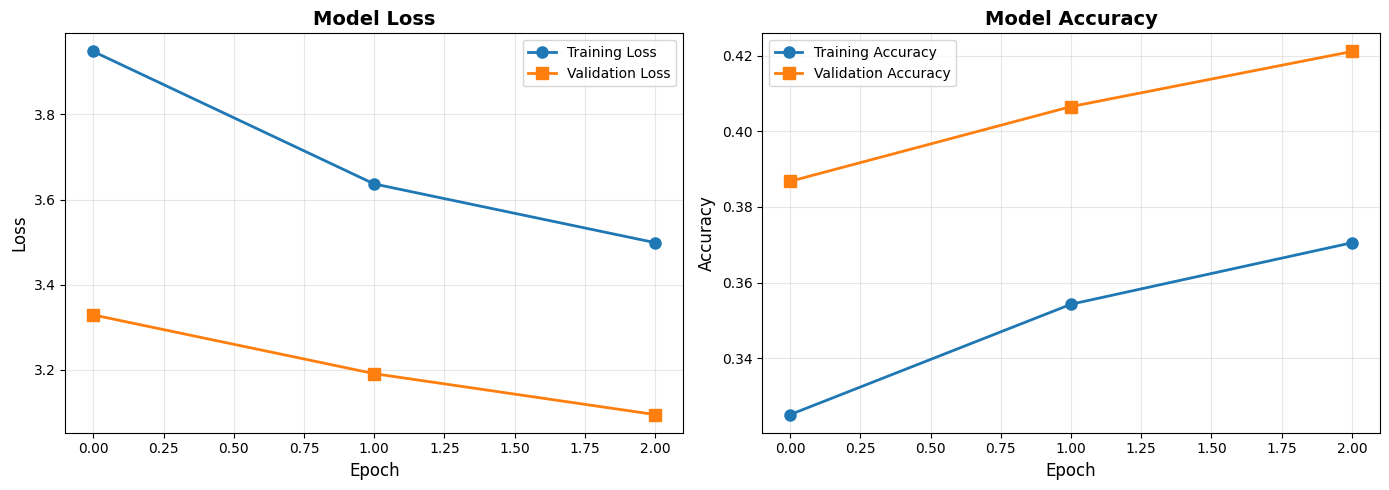

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'o-', label='Training Loss', linewidth=2, markersize=8)
plt.plot(history.history['val_loss'], 's-', label='Validation Loss', linewidth=2, markersize=8)
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['masked_sparse_categorical_accuracy'], 'o-', label='Training Accuracy', linewidth=2, markersize=8)
plt.plot(history.history['val_masked_sparse_categorical_accuracy'], 's-', label='Validation Accuracy', linewidth=2, markersize=8)
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
initial_train_loss = history.history['loss'][0]
final_train_loss = history.history['loss'][-1]
loss_improvement = ((initial_train_loss - final_train_loss) / initial_train_loss) * 100

initial_train_acc = history.history['masked_sparse_categorical_accuracy'][0]
final_train_acc = history.history['masked_sparse_categorical_accuracy'][-1]
acc_improvement = ((final_train_acc - initial_train_acc) / initial_train_acc) * 100

print(f"  Loss improved by: {loss_improvement:.1f}%")
print(f"  Accuracy improved by: {acc_improvement:.1f}%")

  Loss improved by: 11.4%
  Accuracy improved by: 14.0%


In [ ]:
num_eval_samples = min(100, len(val_idx))  # Evaluate on subset for speed
eval_indices = np.random.choice(val_idx, num_eval_samples, replace=False)

eval_questions = [original_questions[i] for i in eval_indices]
eval_references = [original_answers[i] for i in eval_indices]

print(f"\nGenerating predictions for {num_eval_samples} samples...")
predictions = []

for i, question in enumerate(eval_questions):
    if (i + 1) % 20 == 0:
        print(f"  Progress: {i+1}/{num_eval_samples}")

    inputs = tokenizer(
        question,
        return_tensors="tf",
        max_length=MAX_INPUT_LENGTH,
        truncation=True,
        padding='max_length'
    )

    outputs = model.generate(
        input_ids=inputs['input_ids'],
        attention_mask=inputs['attention_mask'],
        max_length=MAX_TARGET_LENGTH,
        num_beams=4,
        early_stopping=True
    )

    pred = tokenizer.decode(outputs[0], skip_special_tokens=True)
    predictions.append(pred)


Generating predictions for 100 samples...
  Progress: 20/100
  Progress: 40/100
  Progress: 60/100
  Progress: 80/100
  Progress: 100/100


In [ ]:
bleu_scores = []
smoothing = SmoothingFunction()

for ref, pred in zip(eval_references, predictions):
    ref_tokens = ref.split()
    pred_tokens = pred.split()

    score = sentence_bleu(
        [ref_tokens],
        pred_tokens,
        smoothing_function=smoothing.method1
    )
    bleu_scores.append(score)

avg_bleu = np.mean(bleu_scores)
print(f"  Average BLEU Score: {avg_bleu:.4f}")

  Average BLEU Score: 0.0247


In [ ]:
if ROUGE_AVAILABLE:
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []

    for ref, pred in zip(eval_references, predictions):
        scores = scorer.score(ref, pred)
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)

    print(f"  ROUGE-1 (F1): {np.mean(rouge1_scores):.4f}")
    print(f"  ROUGE-2 (F1): {np.mean(rouge2_scores):.4f}")
    print(f"  ROUGE-L (F1): {np.mean(rougeL_scores):.4f}")

In [ ]:
total_loss = 0
total_tokens = 0

for batch in val_dataset.take(50):
    inputs, labels = batch
    outputs = model(
        input_ids=inputs['input_ids'],
        attention_mask=inputs['attention_mask'],
        labels=inputs['labels'],
        training=False
    )

    batch_loss = outputs.loss

    mask = tf.not_equal(inputs['labels'], -100)
    num_tokens = tf.reduce_sum(tf.cast(mask, tf.float32))

    total_loss += float(batch_loss) * float(num_tokens)
    total_tokens += float(num_tokens)

perplexity = np.exp(total_loss / total_tokens)
print(f"Perplexity: {perplexity:.4f}")


Perplexity: 21.5236


In [ ]:
all_ref_tokens = []
all_pred_tokens = []

vocab = set()
for ref in eval_references:
    vocab.update(ref.split())
for pred in predictions:
    vocab.update(pred.split())

vocab = sorted(list(vocab))
token_to_idx = {token: idx for idx, token in enumerate(vocab)}

In [ ]:
for ref, pred in zip(eval_references, predictions):
    ref_vec = [1 if token in ref.split() else 0 for token in vocab]
    pred_vec = [1 if token in pred.split() else 0 for token in vocab]
    all_ref_tokens.append(ref_vec)
    all_pred_tokens.append(pred_vec)

all_ref_flat = np.array(all_ref_tokens).flatten()
all_pred_flat = np.array(all_pred_tokens).flatten()

token_f1 = f1_score(all_ref_flat, all_pred_flat, average='binary', zero_division=0)
token_precision = precision_score(all_ref_flat, all_pred_flat, average='binary', zero_division=0)
token_recall = recall_score(all_ref_flat, all_pred_flat, average='binary', zero_division=0)

print(f"  Token Precision: {token_precision:.4f}")
print(f"  Token Recall: {token_recall:.4f}")
print(f"  Token F1 Score: {token_f1:.4f}")

  Token Precision: 0.3042
  Token Recall: 0.1387
  Token F1 Score: 0.1905



  Macro F1 Score: 0.1925

EVALUATION METRICS SUMMARY
         Metric     Score
           BLEU  0.024663
       F1-Score  0.192511
     Perplexity 21.523636
Token Precision  0.304156
   Token Recall  0.138654


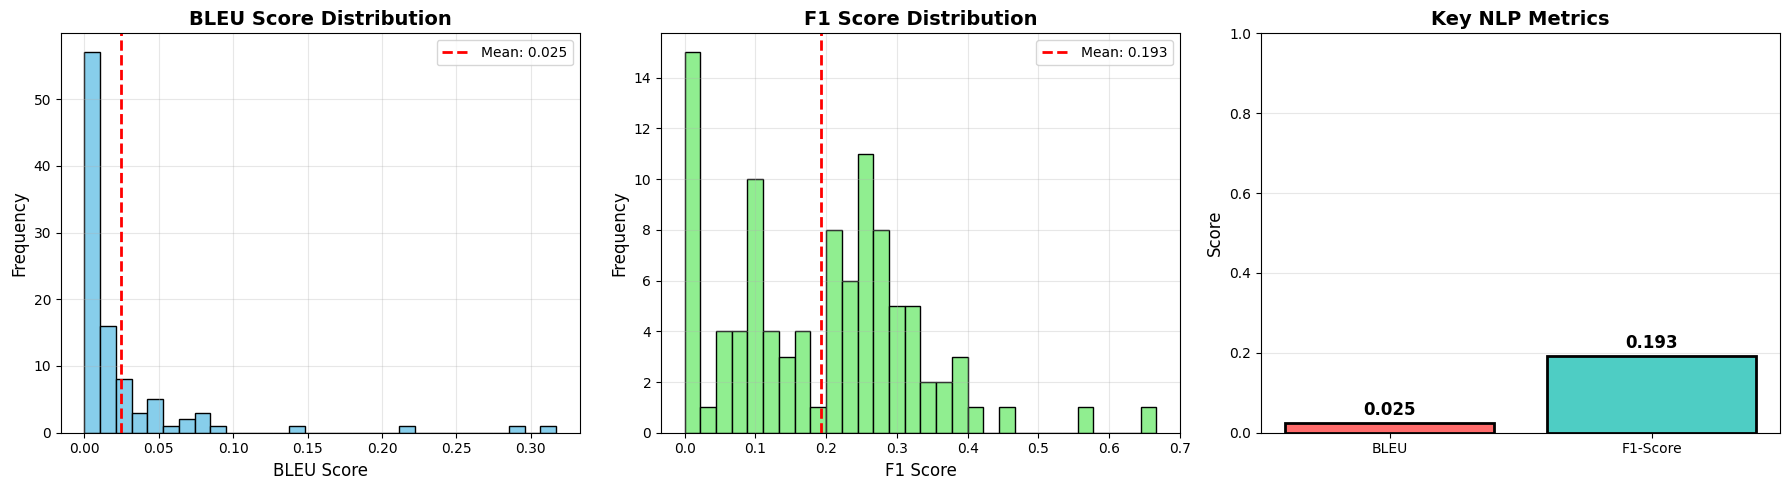

In [ ]:
def calculate_f1_score(references, predictions):
    """Calculate macro-averaged F1 score across all samples"""
    f1_scores = []

    for ref, pred in zip(references, predictions):
        ref_tokens = set(ref.lower().split())
        pred_tokens = set(pred.lower().split())

        if len(pred_tokens) == 0:
            f1_scores.append(0.0)
            continue

        # Calculate precision and recall
        common = ref_tokens.intersection(pred_tokens)
        precision = len(common) / len(pred_tokens) if len(pred_tokens) > 0 else 0
        recall = len(common) / len(ref_tokens) if len(ref_tokens) > 0 else 0

        # Calculate F1
        if precision + recall > 0:
            f1 = 2 * (precision * recall) / (precision + recall)
        else:
            f1 = 0.0

        f1_scores.append(f1)

    return np.mean(f1_scores), f1_scores

macro_f1, f1_scores = calculate_f1_score(eval_references, predictions)
print(f"\n  Macro F1 Score: {macro_f1:.4f}")

metrics_summary = {
    'Metric': ['BLEU', 'F1-Score', 'Perplexity', 'Token Precision', 'Token Recall'],
    'Score': [avg_bleu, macro_f1, perplexity, token_precision, token_recall]
}

if ROUGE_AVAILABLE:
    metrics_summary['Metric'].extend(['ROUGE-1', 'ROUGE-2', 'ROUGE-L'])
    metrics_summary['Score'].extend([np.mean(rouge1_scores), np.mean(rouge2_scores), np.mean(rougeL_scores)])

metrics_df = pd.DataFrame(metrics_summary)

print("\n" + "="*60)
print("EVALUATION METRICS SUMMARY")
print("="*60)
print(metrics_df.to_string(index=False))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(bleu_scores, bins=30, color='skyblue', edgecolor='black')
axes[0].axvline(avg_bleu, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_bleu:.3f}')
axes[0].set_title('BLEU Score Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('BLEU Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(f1_scores, bins=30, color='lightgreen', edgecolor='black')
axes[1].axvline(macro_f1, color='red', linestyle='--', linewidth=2, label=f'Mean: {macro_f1:.3f}')
axes[1].set_title('F1 Score Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('F1 Score', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

key_metrics = ['BLEU', 'F1-Score']
key_scores = [avg_bleu, macro_f1]
colors = ['#FF6B6B', '#4ECDC4']

axes[2].bar(key_metrics, key_scores, color=colors, edgecolor='black', linewidth=2)
axes[2].set_title('Key NLP Metrics', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Score', fontsize=12)
axes[2].set_ylim(0, 1)
axes[2].grid(True, alpha=0.3, axis='y')

for i, (metric, score) in enumerate(zip(key_metrics, key_scores)):
    axes[2].text(i, score + 0.02, f'{score:.3f}', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
def generate_answer(question, max_length=128, num_beams=4, temperature=0.7):
    """Generate answer for a given question"""
    cleaned_question = clean_text(question)
    input_text = f"question: {cleaned_question}"

    inputs = tokenizer(
        input_text,
        return_tensors="tf",
        max_length=MAX_INPUT_LENGTH,
        truncation=True,
        padding='max_length'
    )

    outputs = model.generate(
        input_ids=inputs['input_ids'],
        attention_mask=inputs['attention_mask'],
        max_length=max_length,
        num_beams=num_beams,
        early_stopping=True,
        no_repeat_ngram_size=2,
        temperature=temperature,
        do_sample=False
    )

    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

In [ ]:
test_questions = [
    "What is the best fertilizer for wheat?",
    "How to control pests in tomato plants?",
    "When should I harvest rice?",
    "What causes yellowing of leaves in crops?",
    "How much water do potato plants need?",
    "Best season for planting corn?",
    "How to prevent fungal diseases in plants?"
]

for i, q in enumerate(test_questions, 1):
    answer = generate_answer(q)
    print(f"\n{i}. Question: {q}")
    print(f"   Answer: {answer}")
    print("-" * 60)






1. Question: What is the best fertilizer for wheat?
   Answer: best fertilizer wheat
------------------------------------------------------------

2. Question: How to control pests in tomato plants?
   Answer: Control pest tomato plant by controlling pests
------------------------------------------------------------

3. Question: When should I harvest rice?
   Answer: harvesting
------------------------------------------------------------

4. Question: What causes yellowing of leaves in crops?
   Answer: yellowing leaf crop
------------------------------------------------------------

5. Question: How much water do potato plants need?
   Answer: potato plant requires a large amount of water to grow.
------------------------------------------------------------

6. Question: Best season for planting corn?
   Answer: best season planting corn
------------------------------------------------------------

7. Question: How to prevent fungal diseases in plants?
   Answer: prevent fungal dise